In [11]:
import sys
import os
import scanpy as sc
import scvelo as scv
import pandas as pd
import numpy as np
import loompy

scv.settings.set_figure_params('scvelo')

# merge loom files
ctrl_fn = "/Users/kriemo/Projects/sc_repos/vanotterloo/data/cellranger/1_control/velocyto/1_control.loom"
mut_fn = "/Users/kriemo/Projects/sc_repos/vanotterloo/data/cellranger/2_mutant/velocyto/2_mutant.loom"


loom_dir = "objects"
if not os.path.exists(loom_dir):
    os.makedirs(loom_dir)

if not os.path.isfile(os.path.join(loom_dir, "combined.loom")):
  loompy.combine([ctrl_fn, mut_fn], os.path.join(loom_dir, "combined.loom"))
 
 
# load
adata = scv.read(os.path.join(loom_dir, "combined.loom"), cache=True)

adata.var_names_make_unique()

mdata = pd.read_csv("../../results/tables/ameloblast_metadata_2019_07_07.tsv.gz", sep="\t")

# get cell ids to match loom object
new_ids = []
for cell in mdata["cell"]:
  fields = cell.split("_")
  sample_id = fields[0] + "_" + fields[1]
  bc = fields[2] + "x"
  new_id = sample_id + ":" + bc
  new_ids.append(new_id)
  
mdata = mdata.assign(new_id = new_ids)

mdata = mdata[mdata.new_id.isin(list(adata.obs.index.values))]

# reorder cell ids to match loom object
cids = pd.DataFrame({'new_id' : adata.obs.index.values})
mdata = pd.merge(cids, mdata, how = 'left', on = 'new_id')
mdata = mdata.dropna()

#only keep cells found in seurat data
keep_idx = [x in list(mdata["new_id"]) for x in list(adata.obs.index.values)]

adata = adata[keep_idx, :]
adata = adata.copy()

#add cluster annotations

adata.obs['clusters'] = np.array([str(x) for x in mdata["clusters"]])
adata.obs['sample'] = np.array(mdata["sample"])

#add tSNE projections
umap_mat = np.column_stack((np.array(mdata["UMAP_1"]), np.array(mdata["UMAP_2"])))
adata.obsm['X_umap'] = umap_mat

scv.utils.show_proportions(adata)



Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Abundance of ['spliced', 'unspliced', 'ambiguous']: [0.76 0.2  0.04]


In [14]:
print(adata)

AnnData object with n_obs × n_vars = 5109 × 27998 
    obs: 'Clusters', '_X', '_Y', 'clusters', 'sample'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'


In [15]:
scv.pp.filter_and_normalize(adata, n_top_genes=4000)    

Normalized count data: X, spliced, unspliced.
Logarithmized X.


In [16]:
print(adata.X)

  (0, 16)	1.5215689
  (0, 24)	1.5215689
  (0, 46)	1.5215689
  (0, 77)	1.5215689
  (0, 214)	1.5215689
  (0, 264)	1.5215689
  (0, 542)	1.5215689
  (0, 543)	3.7831175
  (0, 571)	2.0990982
  (0, 585)	2.0990982
  (0, 604)	1.5215689
  (0, 613)	1.5215689
  (0, 790)	1.5215689
  (0, 795)	1.5215689
  (0, 1064)	1.5215689
  (0, 1175)	2.7290037
  (0, 1198)	2.0990982
  (0, 1234)	1.5215689
  (0, 1239)	1.5215689
  (0, 1271)	2.4628496
  (0, 1319)	1.5215689
  (0, 1336)	1.5215689
  (0, 1367)	1.5215689
  (0, 1449)	1.5215689
  (0, 1483)	1.5215689
  :	:
  (5108, 3857)	3.55773
  (5108, 3861)	2.3041463
  (5108, 3862)	2.259243
  (5108, 3863)	0.19876339
  (5108, 3873)	0.74168324
  (5108, 3881)	0.19876339
  (5108, 3882)	1.1628172
  (5108, 3884)	0.3644949
  (5108, 3895)	0.50662476
  (5108, 3898)	1.1628172
  (5108, 3903)	0.19876339
  (5108, 3918)	0.19876339
  (5108, 3920)	1.1628172
  (5108, 3925)	2.5026286
  (5108, 3928)	1.091601
  (5108, 3939)	0.19876339
  (5108, 3944)	0.19876339
  (5108, 3946)	0.19876339
  (5108

In [17]:
scv.pp.moments(adata, n_pcs=20, n_neighbors=30)


computing neighbors
    finished (0:00:01) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


In [18]:
scv.tl.velocity(adata)


computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [20]:
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


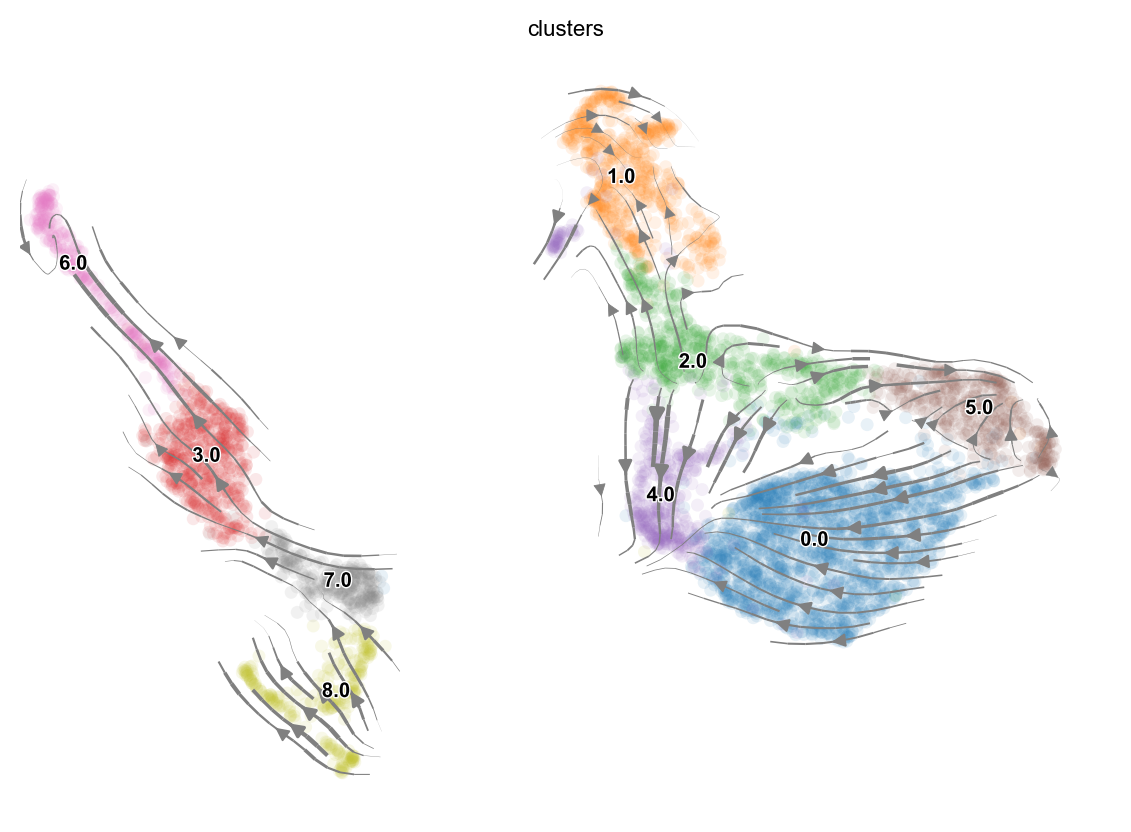

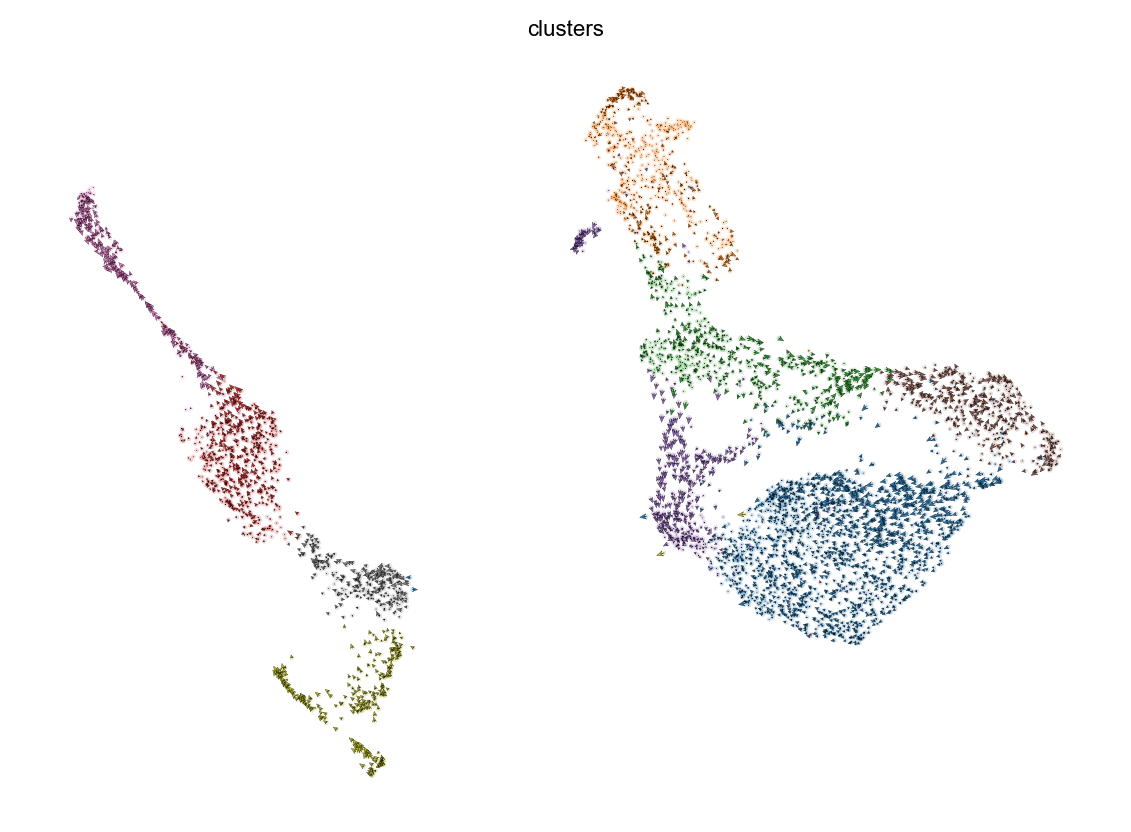

In [22]:
scv.pl.velocity_embedding_stream(adata, basis='umap')
scv.pl.velocity_embedding(adata, basis='umap')

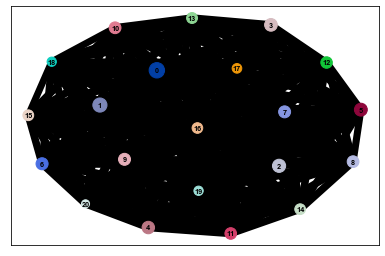

In [10]:
sc.tl.paga(adata, groups = "Clusters")
#sc.tl.paga(adata, groups = "Clusters", use_rna_velocity=True)
sc.pl.paga(adata)
#sc.pl.paga(adata, transitions='transitions_confidence')

In [7]:
adata.obs

,Clusters,_X,_Y,clusters,sample,initial_size_unspliced,initial_size_spliced,initial_size,n_counts,velocity_self_transition
index,,,,,,,,,,
1_control:AAAGTGAGTCTGTGGCx,11,-12.668505,-47.725479,0.0,control,84,806,806.0,2884.999756,0.384790
1_control:AAAGGATTCAGTGGGAx,13,-18.861511,27.186083,3.0,control,7796,21512,21512.0,2885.000000,0.045687
1_control:AAAGAACCAAATGGCGx,2,7.929146,-56.151077,0.0,control,131,1980,1980.0,2885.000000,0.454646
1_control:AAACGCTCAGTGGCTCx,5,-31.061535,2.308393,0.0,control,117,1442,1442.0,2885.000244,0.327339
1_control:AAACGAAAGTGCGACAx,0,-4.869218,-15.956539,0.0,control,85,763,763.0,2885.000000,0.350929
...,...,...,...,...,...,...,...,...,...,...
2_mutant:TTTGACTGTCGCACACx,14,-19.176531,1.883803,6.0,mutant,8929,23019,23019.0,2885.000244,0.028199
2_mutant:TTTCGATGTAGCTTGTx,5,-5.478233,-23.339767,0.0,mutant,118,2067,2067.0,2885.000488,0.344289
2_mutant:TTTGATCCAGGAGGTTx,2,-21.670012,33.342709,2.0,mutant,135,2229,2229.0,2885.000000,0.455660
